In [240]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize

### Utils

In [2]:
def correlation_matrix(beta,tenors=[]):
    # creat correlation matrix rho
    N = len(tenors)
    tenors_col = np.repeat(np.array(tenors).reshape(-1,1),N,axis=1)
    tenors_row = np.repeat(np.array(tenors).reshape(1,-1),N,axis=0)
    return np.exp(-beta*np.abs(tenors_col-tenors_row))

In [3]:
tenors = [1,2,3,4,5]
rho = correlation_matrix(0.5,tenors)

In [4]:
U = np.linalg.cholesky(rho)

In [406]:
def simulation(Initial_L,delta,sigma,rho,step,T0,Rup):
    """
    [ln L_tk+1^0            [ ln L_tk^0                [         ...                            [sigma_0^2  sigma_0 ...
     ln L_tk+1^1       =      ln L_tk^1     +   diag       rho_i_j * delta * L_tk^j        *          0       sigma_1^2  sigma_1 ...
     ...                      ...                                ...                                           ...
     ln L_tk+1^N-1]           ln L_tk^N-1]                                          ]N*N                                         sigma_N-1^2]
    
    
    
            -          0.5h*[ sigma_0^2     +   diag [          ...            *  [U_0_0  U_0_1  ...         *  [ x_0_k
                              sigma_1^2                  sigma_i * sqrt(h)           0    U_1_1  ...              x_1_k
                              ...                               ...                              ...              ...
                              simga_N-1^2 ]                                ]                     U_N-1_N-1]       x_N-1_k ]
    
    
    
    """
    h = step
    M = int(T0/h)
    N = len(Initial_L)
    sigma = np.array(sigma)
    result = -np.Inf*np.ones(N*M).reshape(N,M)
    result[:,0] = np.array(np.log(Initial_L))
    for i in range(M-1):
        X = 2*(np.random.binomial(1,0.5,N).reshape(-1,1)-.5)
        temp_vec = result[:,i]
        temp_L_k = np.exp(temp_vec)
        sigma_eye = np.eye(N)*sigma
        sigma_triu = np.triu(np.repeat(sigma.reshape(-1,1),N,axis=1))
        rho_l = rho * np.repeat((delta*temp_L_k/(1+delta*temp_L_k)).reshape(1,-1),N,axis=0)
        result_temp = h* np.diag(sigma_eye.dot(rho_l.dot(sigma_triu))).reshape(1,-1) - 0.5*h*sigma**2 + np.sqrt(h)*sigma_eye.dot(U.dot(X)).reshape(1,-1)
        
        sigma_max = sigma.max()
        ln_L_hat = result_temp.max() + sigma_max**2*h*N - 0.5*sigma_max**2*h + sigma_max*np.sqrt(h*N)
        
        if ln_L_hat < np.log(Rup):
            # first criteria
            result[:,i+1] = result[:,i]  + result_temp
        else:
            # second criteria
            swap_rate = np.exp(result[:,i]) * (1 + (np.arange(N)+1)*sigma*sigma_max*h + sigma*np.sqrt(h*(np.flip(np.arange(N))+1)))
            second_criteria = R_swap(swap_rate,delta)
            if second_criteria < Rup:
                result[:,i+1] = result[:,i]  + result_temp
            else:
                ln_L_pi = projection_with_constraint(np.exp(result[:,i]))
                lam_h = np.sqrt(N)*(N*h*sigma_max**2-0.5*h*sigma_max**2+sigma_max*np.sqrt(N*h))
                pi_norm = np.linalg.norm(ln_L_pi-result[:,i])
                p = lam_h/(pi_norm+lam_h)
                u = np.random.rand()
                if u<p:
                    print('stop')
                    result[:,i+1] = ln_L_pi
                    break
                else:
                    print('jump back')
                    result[:,i] = result[:,i] + lam_h*(result[:,i]-ln_L_pi)/pi_norm
                    result[:,i+1] = result[:,i] + result_temp
    return np.exp(result)

In [149]:
sigma = np.array(sigma)

In [151]:
sigma_max = sigma.max()
(np.arange(N)+1)*sigma*sigma_max

array([0.01, 0.02, 0.03, 0.04, 0.05])

In [448]:
for i in tqdm(range(100000)):
    L = simulation(Initial_L,delta=delta,sigma=sigma,rho=rho,step=0.01,T0=10,Rup=0.075)


  0%|          | 10/100000 [00:01<3:40:17,  7.57it/s]

jump back
jump back
stop



  0%|          | 15/100000 [00:01<3:35:09,  7.74it/s]

stop



  0%|          | 24/100000 [00:03<3:51:30,  7.20it/s]

stop


  0%|          | 26/100000 [00:03<3:51:45,  7.19it/s]

jump back


  0%|          | 29/100000 [00:03<3:48:45,  7.28it/s]

stop


  0%|          | 31/100000 [00:04<3:48:17,  7.30it/s]

stop


  0%|          | 40/100000 [00:05<3:40:07,  7.57it/s]

stop


  0%|          | 45/100000 [00:05<3:37:02,  7.68it/s]

stop


  0%|          | 48/100000 [00:06<3:35:30,  7.73it/s]

stop


  0%|          | 63/100000 [00:08<3:34:17,  7.77it/s]

stop


  0%|          | 66/100000 [00:08<3:34:01,  7.78it/s]

jump back
stop


  0%|          | 70/100000 [00:08<3:32:47,  7.83it/s]

stop


  0%|          | 81/100000 [00:10<3:32:50,  7.82it/s]

stop


  0%|          | 86/100000 [00:11<3:33:24,  7.80it/s]

jump back
jump back
stop


  0%|          | 89/100000 [00:11<3:32:28,  7.84it/s]

stop


  0%|          | 105/100000 [00:13<3:32:30,  7.83it/s]

stop


  0%|          | 118/100000 [00:14<3:30:21,  7.91it/s]

jump back
stop


  0%|          | 123/100000 [00:15<3:29:09,  7.96it/s]

stop
stop


  0%|          | 127/100000 [00:16<3:30:56,  7.89it/s]

stop
stop


  0%|          | 136/100000 [00:17<3:31:01,  7.89it/s]

stop


  0%|          | 138/100000 [00:17<3:30:55,  7.89it/s]

jump back
stop


  0%|          | 141/100000 [00:17<3:30:26,  7.91it/s]

jump back
stop


  0%|          | 144/100000 [00:18<3:31:26,  7.87it/s]

jump back
stop


  0%|          | 149/100000 [00:19<3:32:14,  7.84it/s]

stop


  0%|          | 151/100000 [00:19<3:32:26,  7.83it/s]

stop


  0%|          | 157/100000 [00:20<3:34:12,  7.77it/s]

stop


  0%|          | 160/100000 [00:20<3:33:50,  7.78it/s]

jump back
stop


  0%|          | 170/100000 [00:21<3:33:23,  7.80it/s]

jump back
stop


  0%|          | 193/100000 [00:25<3:39:50,  7.57it/s]

KeyboardInterrupt: 

In [449]:
Initial_L = [.05,.05,.05,.05,.05]
sigma = [.1,.1,.1,.1,.1]
rho = correlation_matrix(0.1,[10,11,12,13,14])
delta=1
L = simulation(Initial_L,delta=delta,sigma=sigma,rho=rho,step=0.01,T0=10,Rup=0.075)

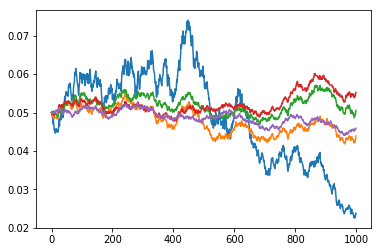

In [450]:
plt.plot(L[0])
plt.plot(L[1])
plt.plot(L[2])
plt.plot(L[3])
plt.plot(L[4])

In [124]:
rho = correlation_matrix(0.1,[1,2,3,4,5])

N = 5
delta = 1

sigma = np.array([.5,.4,.3,.2,.1])
temp_vec = np.log(np.ones(N)*0.4)

temp_L_k = np.exp(temp_vec)

sigma_eye = np.eye(N)*sigma

sigma_eye

sigma_triu = np.triu(np.repeat(sigma.reshape(-1,1),N,axis=1))

sigma_triu

rho_l = rho * np.repeat((delta*temp_L_k/(1+delta*temp_L_k)).reshape(1,-1),N,axis=0)

rho_l[2,4]-rho[2,4]*delta*temp_L_k[4]/(1+temp_L_k[4])

#Verification matrix version
m=sigma_eye.dot(rho_l.dot(sigma_triu))
m=np.diag(m)
m0=sigma[0]**2*rho[0,0]*delta*temp_L_k[0]/(1+temp_L_k[0])
m1=sigma[1]*(sigma[0]*rho[1,0]*delta*temp_L_k[0]/(1+temp_L_k[0])+sigma[1]*rho[1,1]*delta*temp_L_k[1]/(1+temp_L_k[1]))
m2=sigma[2]*(sigma[0]*rho[2,0]*delta*temp_L_k[0]/(1+temp_L_k[0])+sigma[1]*rho[2,1]*delta*temp_L_k[1]/(1+temp_L_k[1])+sigma[2]*rho[2,2]*delta*temp_L_k[2]/(1+temp_L_k[2]))
print(m[0]-m0)
print(m[1]-m1)
print(m[2]-m2)

U = np.linalg.cholesky(rho).T
X = 2*(np.random.binomial(1,0.5,N).reshape(-1,1)-.5)

sigma_eye.dot(U.dot(X))

sigma_eye

0.0
0.0
1.3877787807814457e-17


array([[0.5, 0. , 0. , 0. , 0. ],
       [0. , 0.4, 0. , 0. , 0. ],
       [0. , 0. , 0.3, 0. , 0. ],
       [0. , 0. , 0. , 0.2, 0. ],
       [0. , 0. , 0. , 0. , 0.1]])

In [156]:
def R_swap(Libor,delta=1):
    Libor_cumProd = (1 + delta*Libor).cumprod()
    return ( 1 - 1/Libor_cumProd[-1] )/( delta * (1/Libor_cumProd).sum() )

In [109]:
delta = 1
Libor = L[:,1]
Rswap = R_swap(Libor,delta)
Rswap

0.04989150787269894

In [315]:
def func(x,log_Libor=log_libor):
    return ((x-log_Libor)**2).sum()

In [316]:
def constraint(x,Rup=0.075):
    libor = np.exp(x)
    return R_swap(libor)-Rup

In [317]:
def projection_with_constraint(Libor):
    log_libor = np.log(Libor)
    bnds = [(-np.Inf,0)]*len(log_libor)
    bnds = tuple(bnds)
    x = minimize(func, np.zeros(len(log_libor)), args=(log_libor), constraints={'type':'eq','fun':constraint},bounds=bnds)
    return x.x

In [352]:
def log_libor_0(Libor,Rup=0.075,delta=1):
    Libor_cumprod_inverse = np.flip((1+delta*Libor)).cumprod()
    L0 = (Rup*(1+Libor_cumprod_inverse.sum())+1)/Libor_cumprod_inverse[-1] - 1/delta
    print(L0)
    return np.log(L0)

In [319]:
def func_noconstraint(x,log_Libor=log_libor,Rup=0.075,delta=1):
    x_ = np.zeros(len(x)+1)
    x_[1:] = x
    x = np.exp(x)
    x_[0] = log_libor_0(x,Rup=Rup,delta=delta)
    return ((x_-log_libor)**2).sum()

In [353]:
def projection_without_constraint(Libor,Rup=0.075,delta=1):
    log_libor = np.log(Libor)
    bnds = [(-np.Inf,0)]*(len(log_libor)-1)
    bnds = tuple(bnds)
    x = minimize(func_noconstraint,np.zeros(len(log_libor)-1), args=(log_libor,Rup,delta),bounds=bnds)
#     result = np.zeros(len(x.x)+1)
#     result[1:] = x.x
#     result[0] = log_libor_0(np.exp(x.x),Rup=Rup,delta=delta)
    return x.x

In [451]:
Libor

array([0.07183268, 0.05901033, 0.05740713, 0.05567199, 0.05640056])

In [452]:
pi_1 = projection_with_constraint(Libor)

In [455]:
np.exp(pi_1)

array([0.09640058, 0.07292997, 0.06930854, 0.06579554, 0.06589871])

In [456]:
R_swap(np.exp(pi_1))

0.07500001081262947

In [360]:
np.sqrt(((pi_1-np.log(Libor))**2).sum())

0.46799946646969576

In [361]:
np.linalg.norm(pi_1-np.log(Libor))

0.46799946646969576

In [366]:
np.random.rand()

0.49586689887624336